# Lecture 4: Dynamic Programming

In [1]:
import numpy as np
from scipy.special import softmax
import rldurham as rld

Seed set to 42


actions are discrete with 4 dimensions/#actions
observations are discrete with 16 dimensions/#observations
maximum timesteps is: 100
action space: Discrete(4)
observation space: Discrete(16)


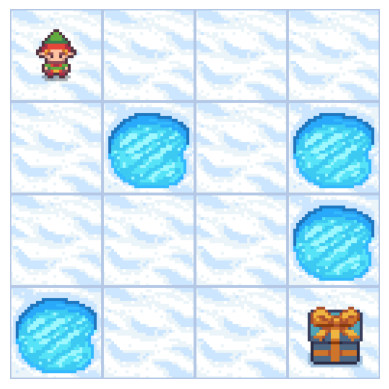

In [2]:
env = rld.make(
    'FrozenLake-v1',         # import the frozen lake environment
    # 'FrozenLake8x8-v1',    # use a bigger version
    render_mode="rgb_array", # for rendering as image/video
    is_slippery=False,       # warning: slippery=True results in very complex environment dynamics where the optimal solution is not very intuitive to humans!
    # desc=["GFFS", "FHFH", "FFFH", "HFFG"],  # define custom map
)
rld.seed_everything(42, env)
# some info
rld.env_info(env, print_out=True)
print('action space: ' + str(env.action_space))
print('observation space: ' + str(env.observation_space))
rld.render(env)

next state: 1
terminated: False
truncated: False
    reward: 0.0
      info: {'prob': 1.0}


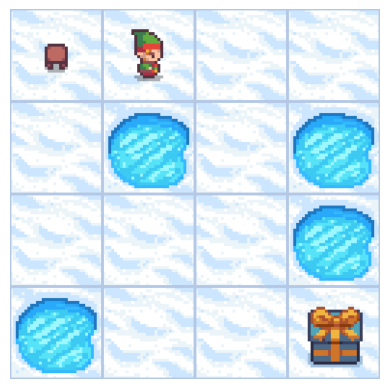

In [3]:
# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

# lets do an example step for the policy
env.reset()
next_state, reward, term, trunc, info = env.step(RIGHT)
print('=============')
print('next state: ' + str(next_state))
print('terminated: ' + str(term))
print('truncated: ' + str(trunc))
print('    reward: ' + str(reward))
print('      info: ' + str(info))
rld.render(env, clear=False)

**Policy evaluation**

In [4]:
def policy_evaluation(env, policy, gamma=1, theta=1e-8, draw=False):
    V = np.zeros(env.observation_space.n)
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            Vs = 0
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in env.P[s][a]:
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if draw:
            rld.plot_frozenlake(env=env, v=V, policy=policy, draw_vals=True)
        if delta < theta:
            break
    return V

In [5]:
# lets start with a random policy, in this case there's a 1/4 probability of taking any action at every 4x4 state
policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n

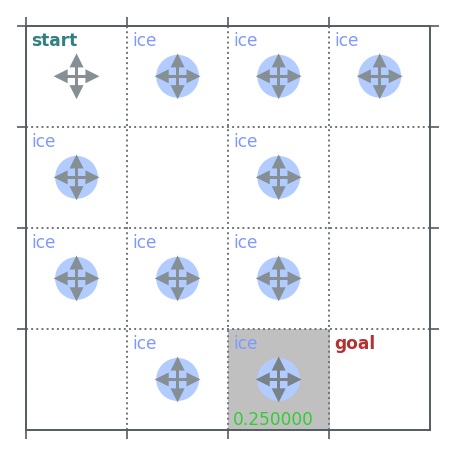

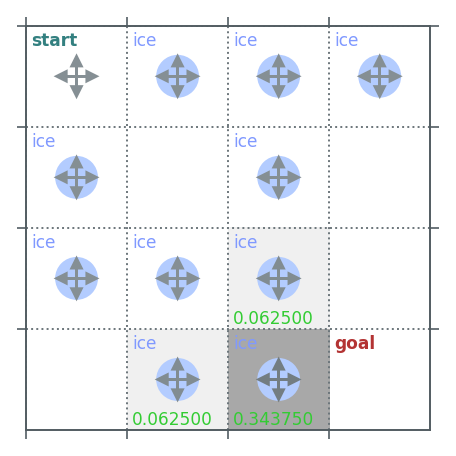

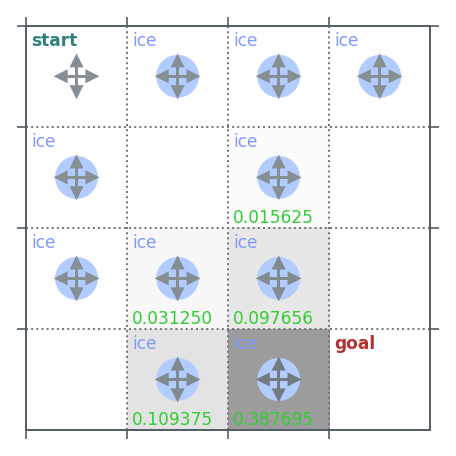

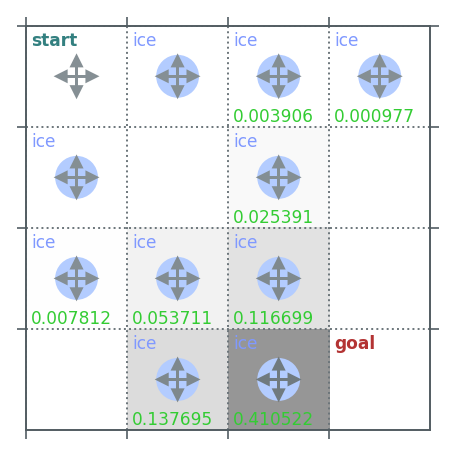

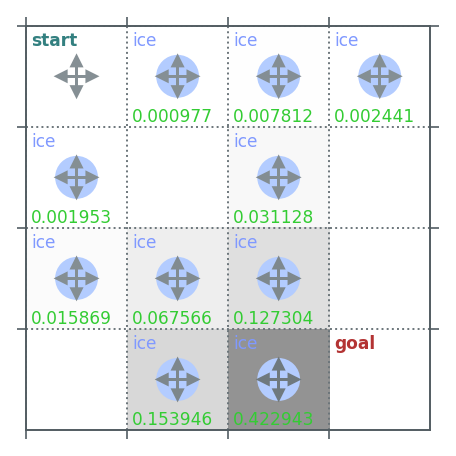

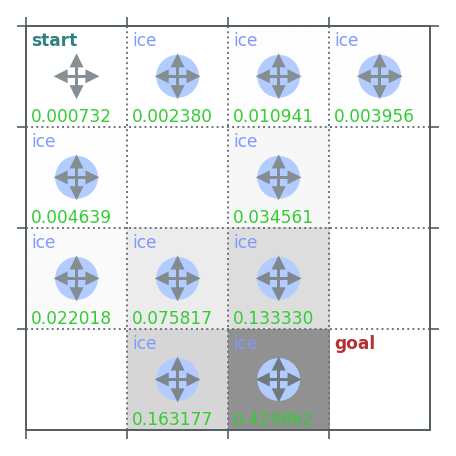

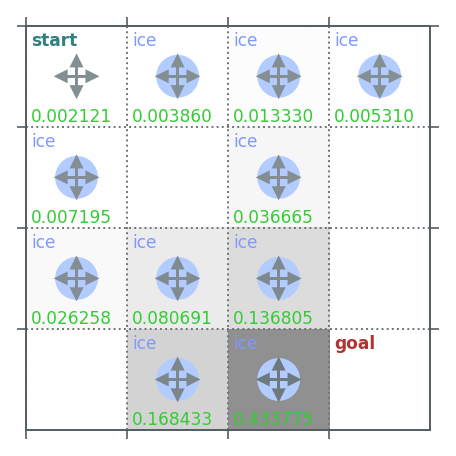

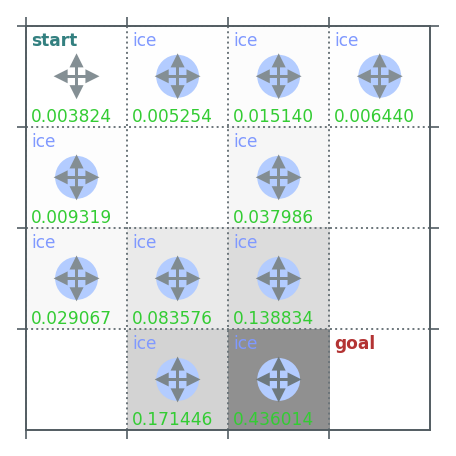

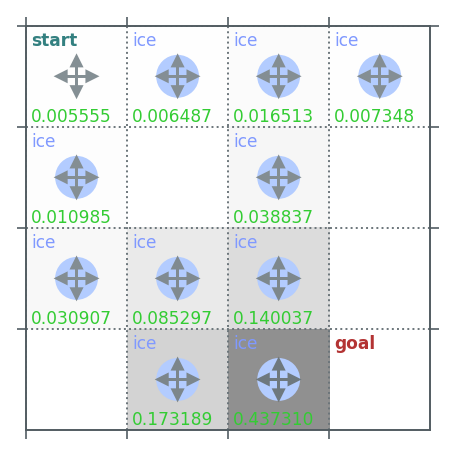

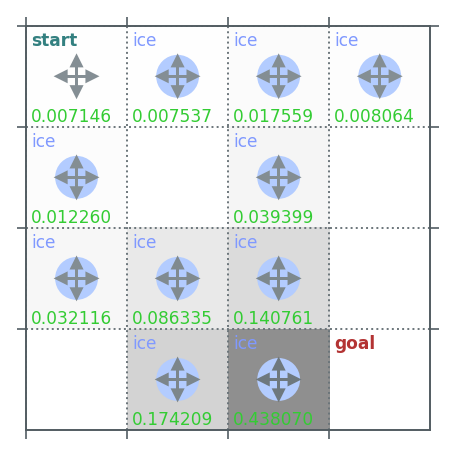

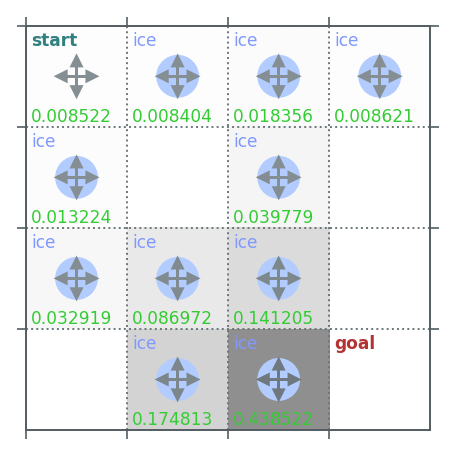

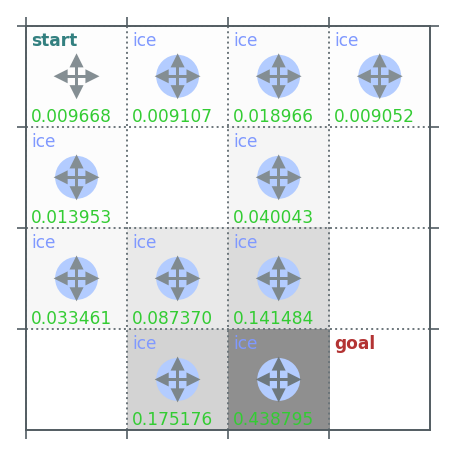

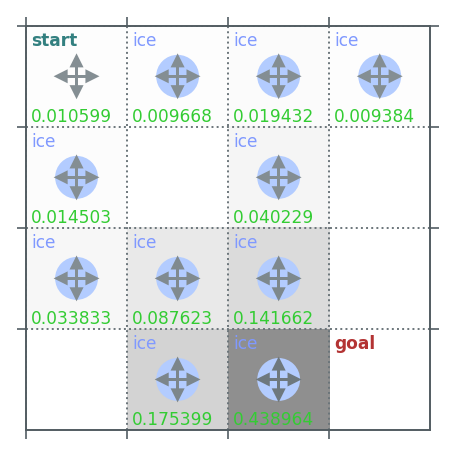

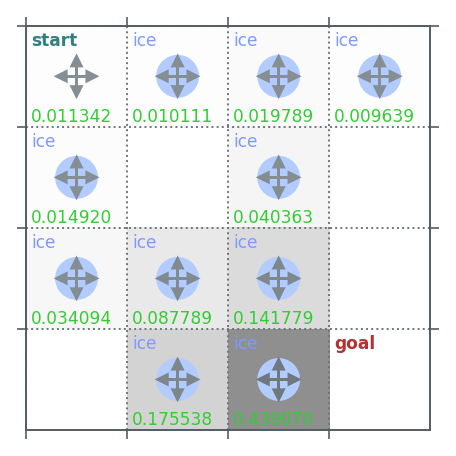

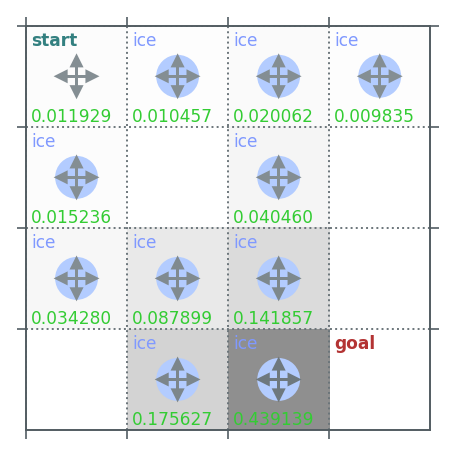

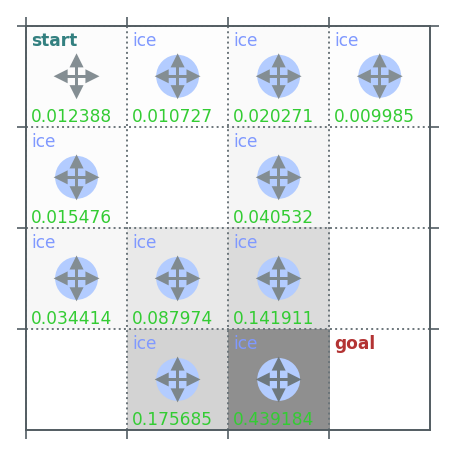

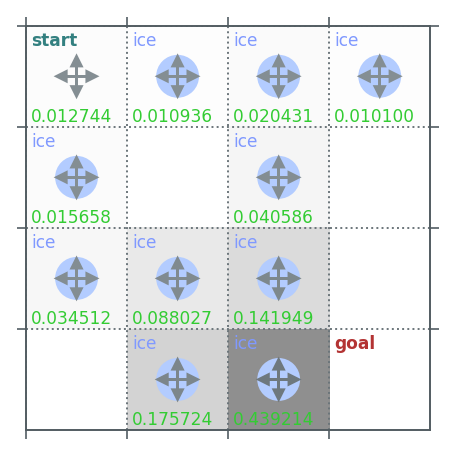

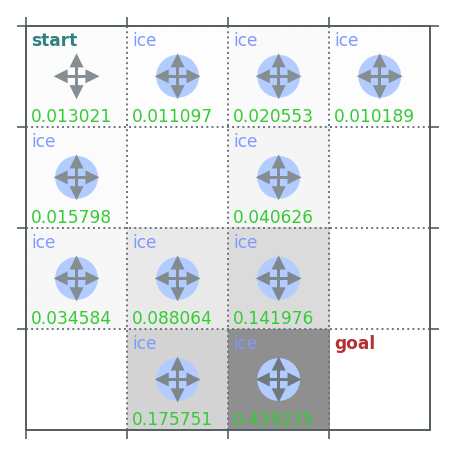

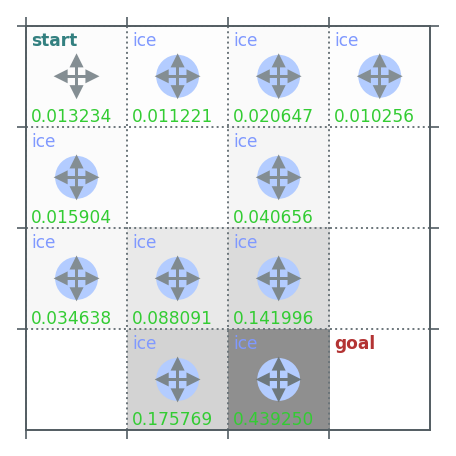

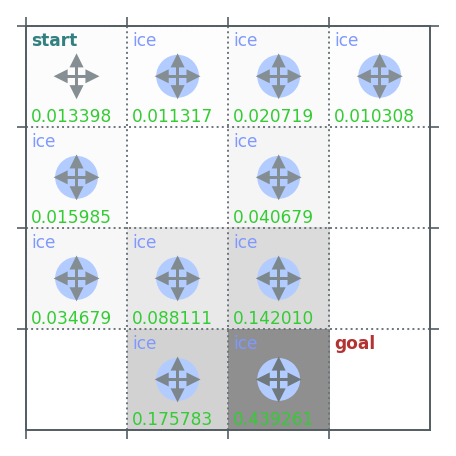

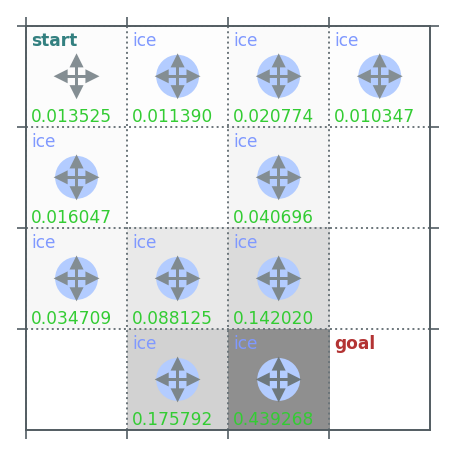

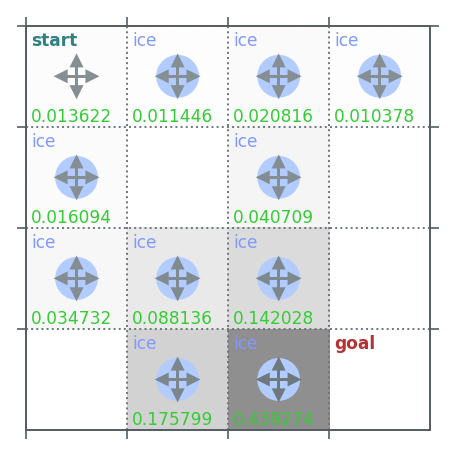

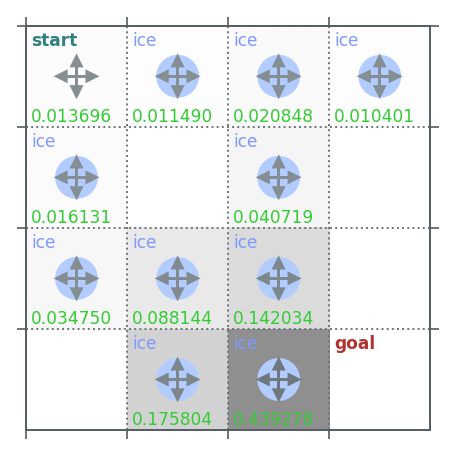

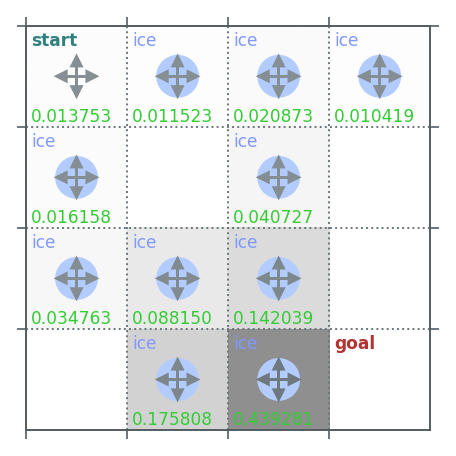

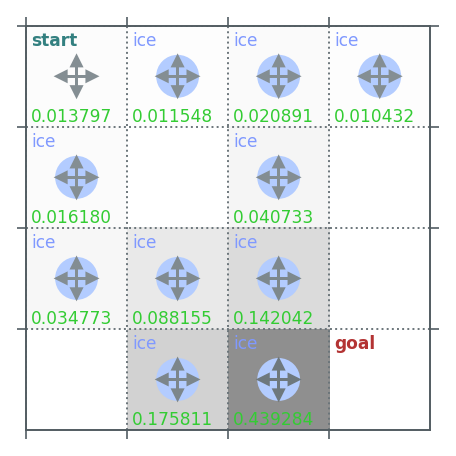

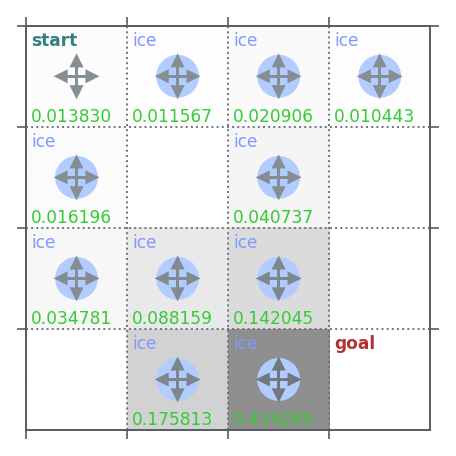

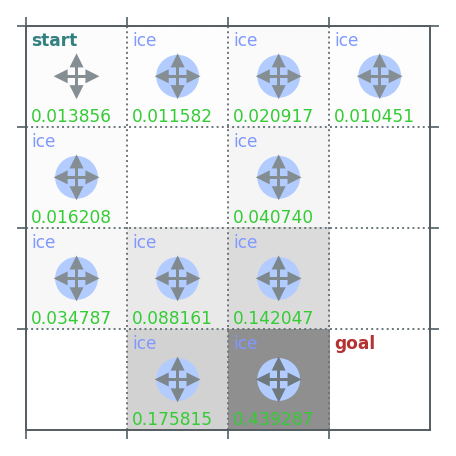

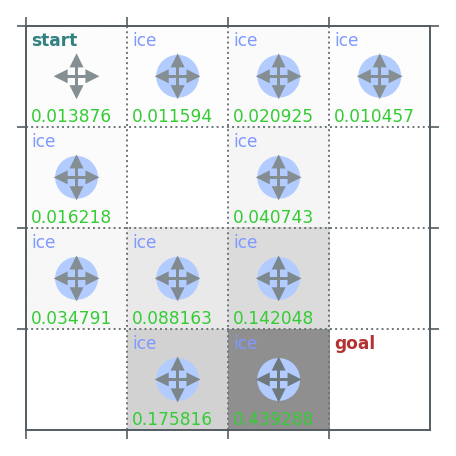

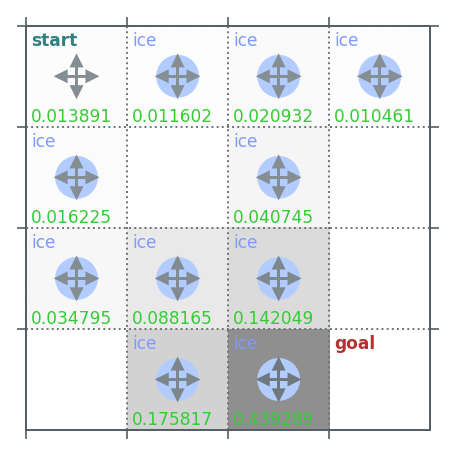

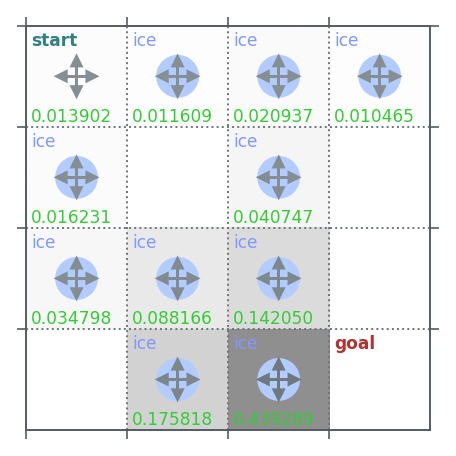

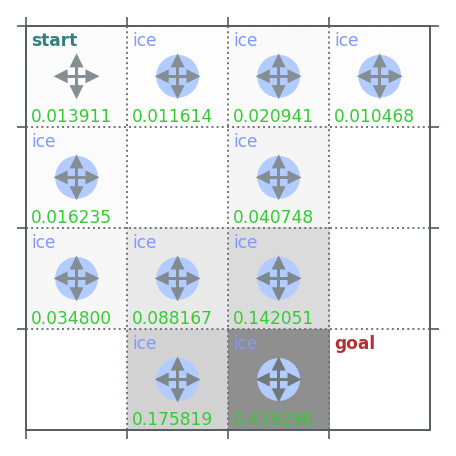

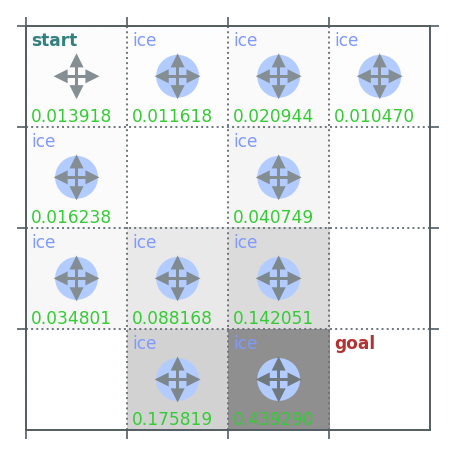

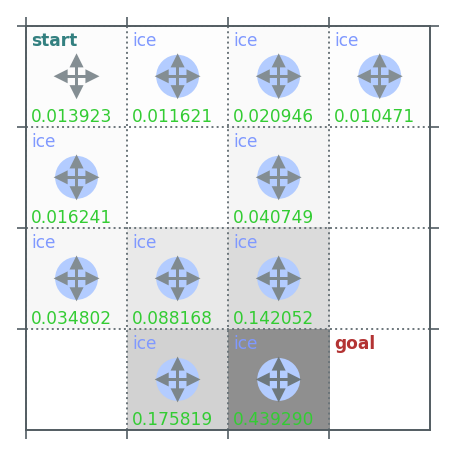

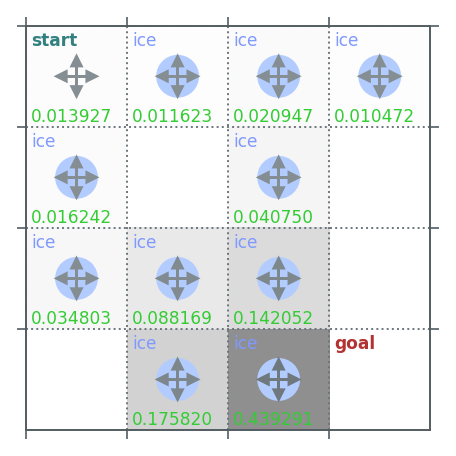

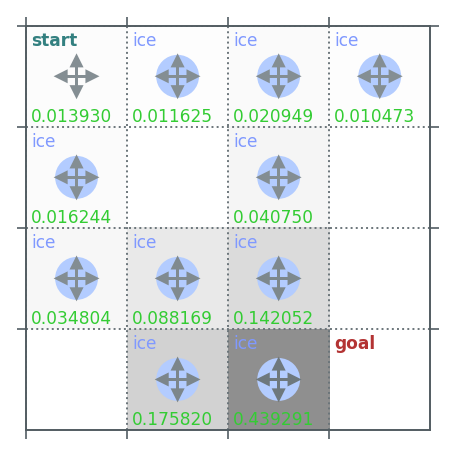

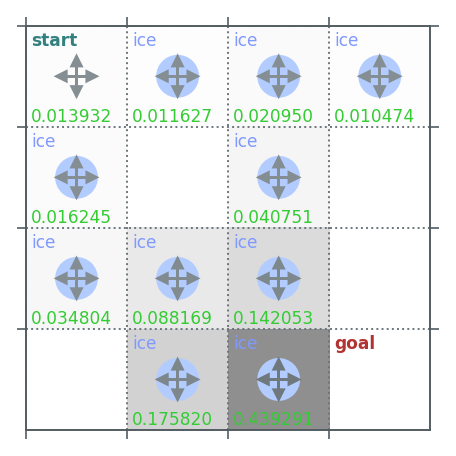

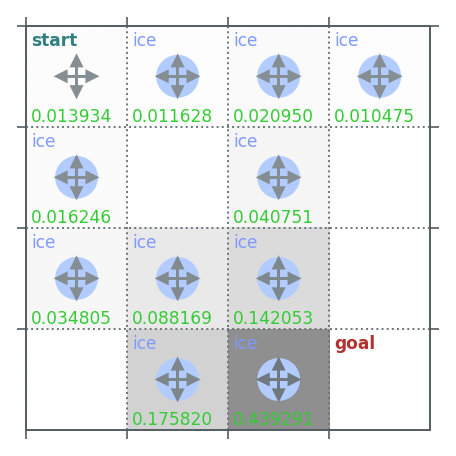

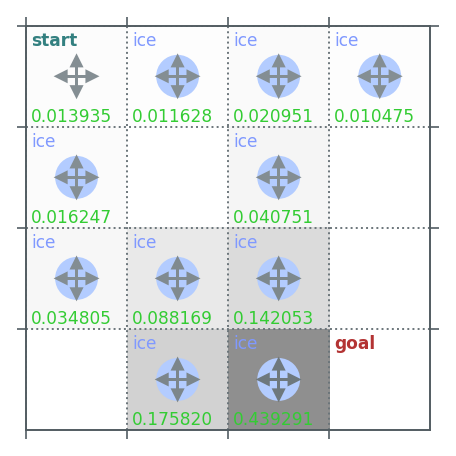

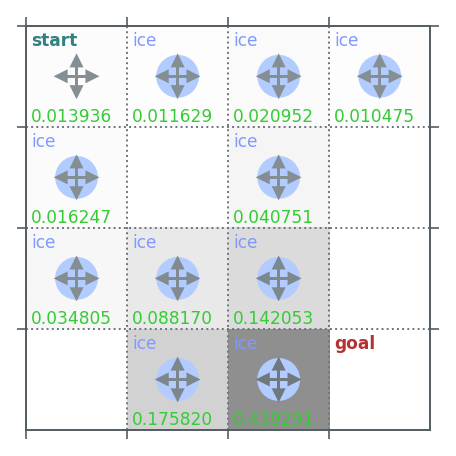

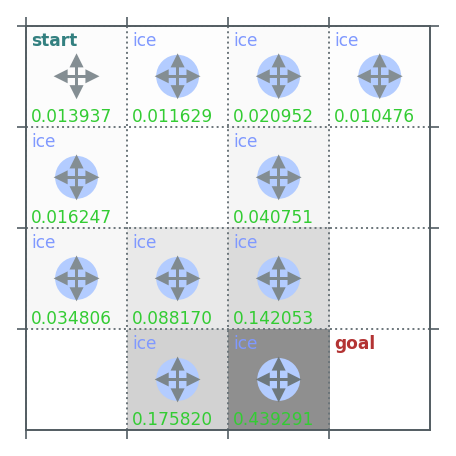

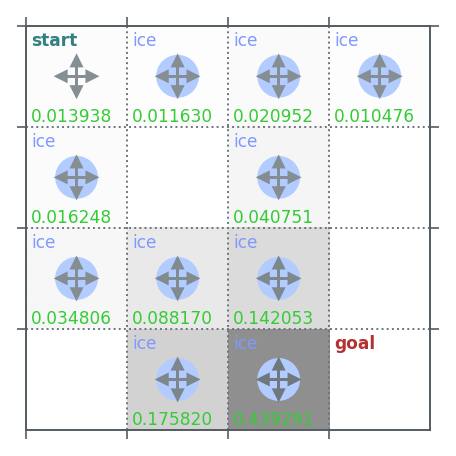

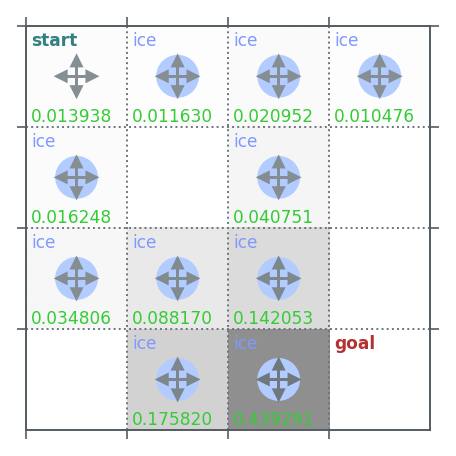

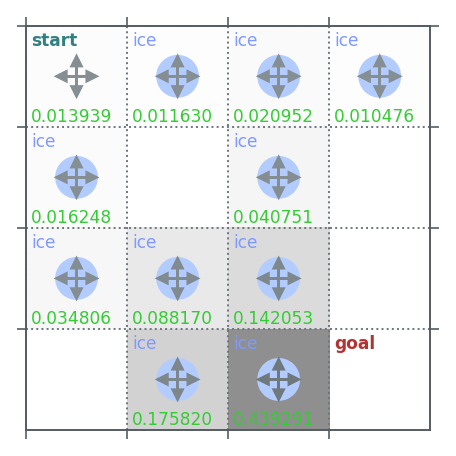

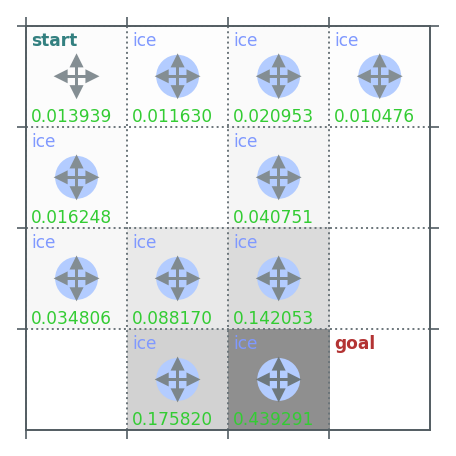

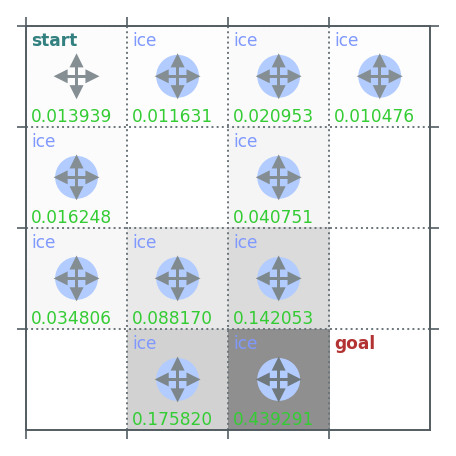

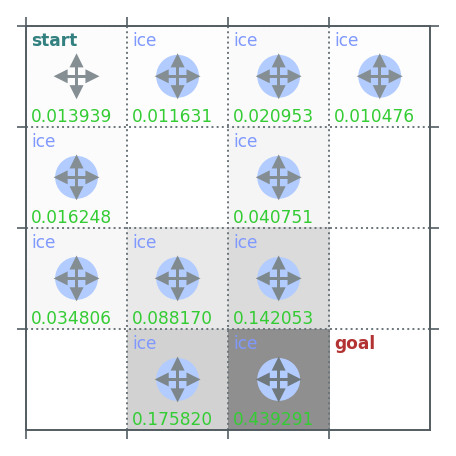

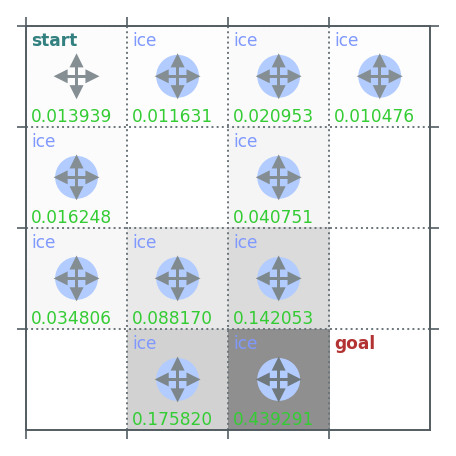

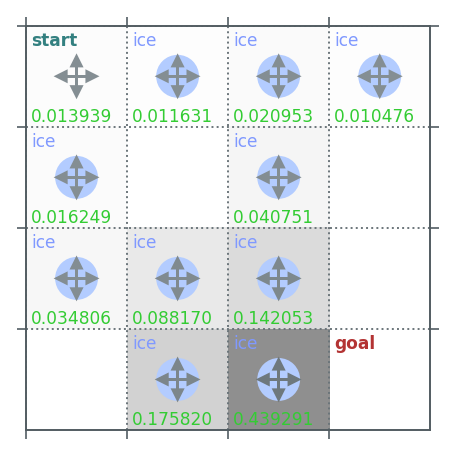

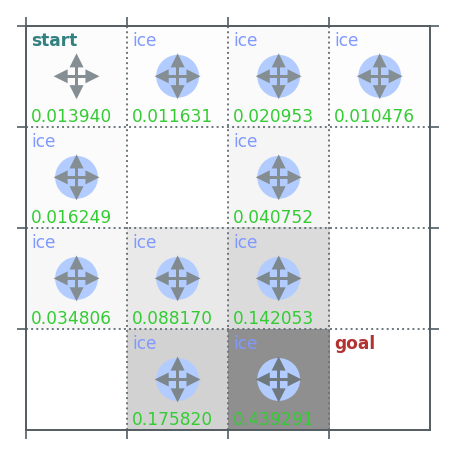

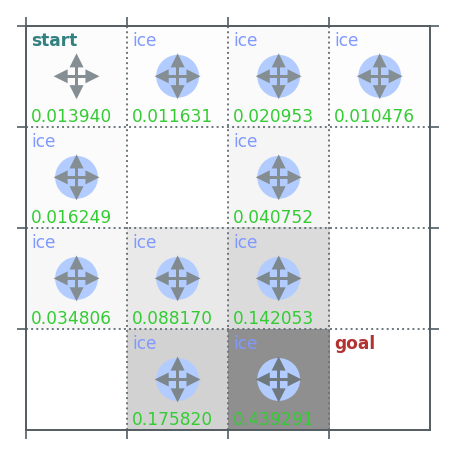

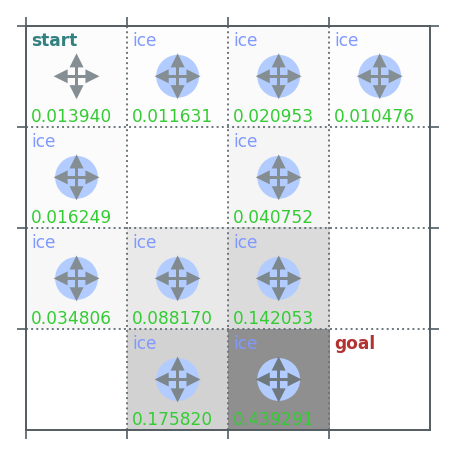

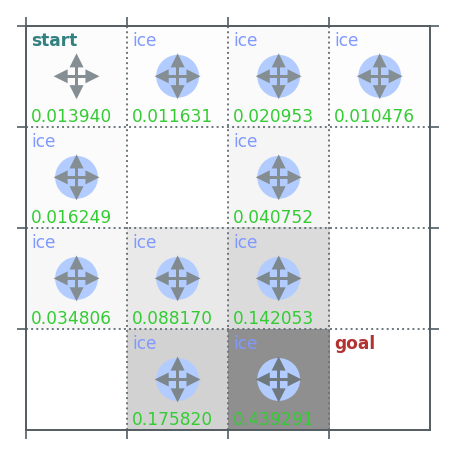

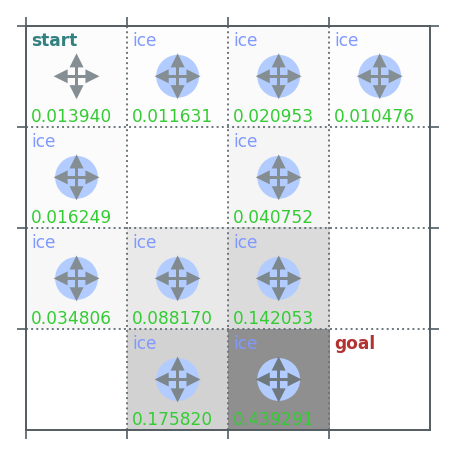

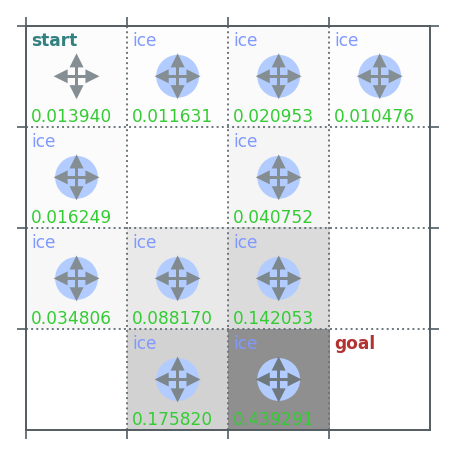

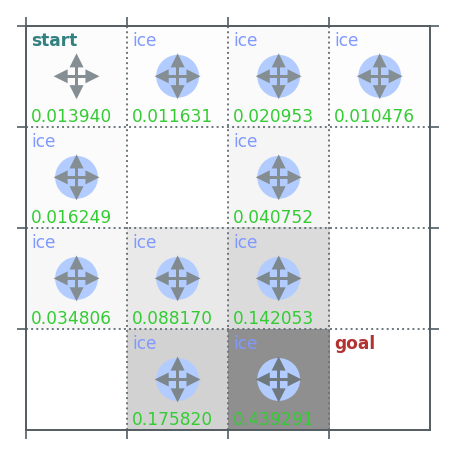

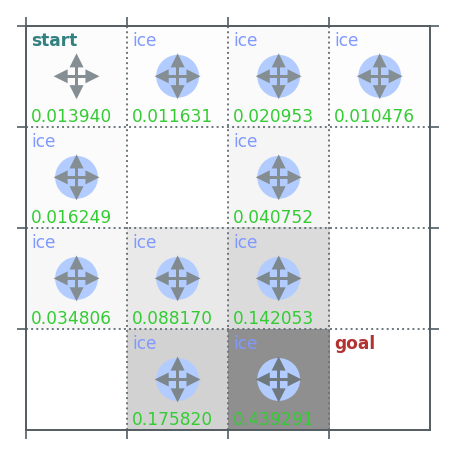

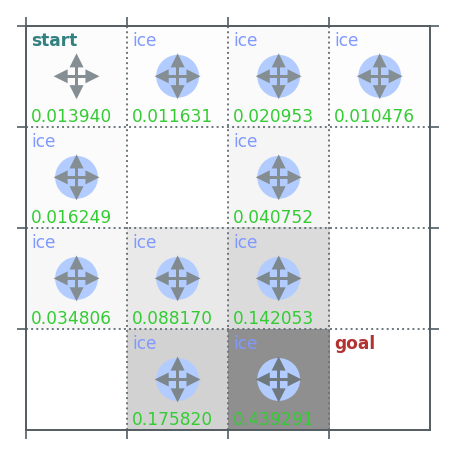

In [6]:
# evaluate this policy (change draw=True to show steps, and ensure environment is 'FrozenLake-v1' for the exact same steps in the lecture)
V = policy_evaluation(env, policy, draw=True)

Get $q_\pi$ form $v_\pi$ by a one-step look ahead

In [7]:
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        for prob, next_state, reward, done in env.P[s][a]:
            q[a] += prob * (reward + gamma * V[next_state])
    return q

In [8]:
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.observation_space.n, env.action_space.n]) / env.action_space.n
    for s in range(env.observation_space.n):
        q = q_from_v(env, V, s, gamma)

        # # deterministic policy (will always choose one specific an action and does not capture the distribution)
        # policy[s][np.argmax(q)] = 1

        # stochastic optimal policy (puts equal probability on all maximizing actions)
        best_a = np.argwhere(q==np.max(q)).flatten()
        policy[s] = np.sum([np.eye(env.action_space.n)[i] for i in best_a], axis=0) / len(best_a)

        # # softmax policy that adds some exploration
        # policy[s] = softmax(q / 0.01)

    return policy

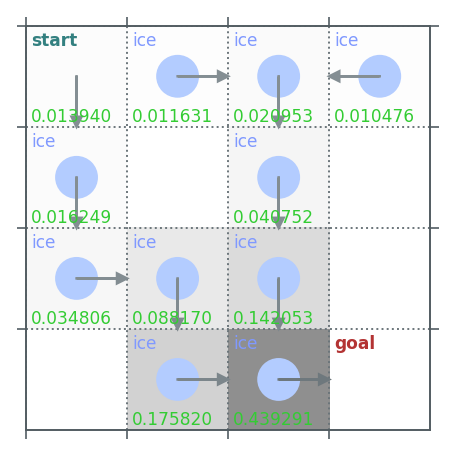

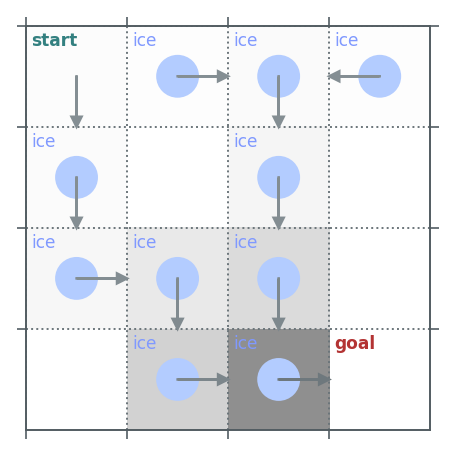

In [9]:
# plot the policy from a single greedy improvement step after policy evaluation
policy = policy_improvement(env, V)
rld.plot_frozenlake(env, V, policy, draw_vals=True)
rld.plot_frozenlake(env, V, policy, draw_vals=False)

In [10]:
# lets from here on use a larger grid world
env = rld.make('FrozenLake8x8-v1', is_slippery=False)
rld.seed_everything(42, env)
policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
V = policy_evaluation(env, policy, draw=False)

Seed set to 42


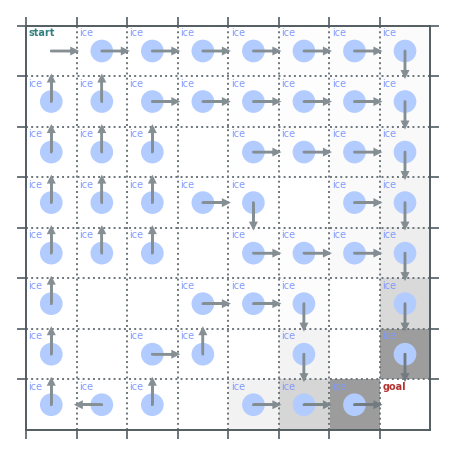

In [11]:
# show improved policy from the policy evaluation, for the 8x8 case it's still not great
new_policy = policy_improvement(env, V)
rld.plot_frozenlake(env, V, new_policy)

In [12]:
# now solve the MDP by policy iteration
def policy_iteration(env, gamma=1, theta=1e-8):
    policy = np.ones([env.observation_space.n, env.action_space.n]) / env.action_space.n
    while True:

        # evaluate the policy (get the value function)
        V = policy_evaluation(env, policy, gamma, theta)

        # greedily choose the best action
        new_policy = policy_improvement(env, V)

        if np.max(abs(policy_evaluation(env, policy) - policy_evaluation(env, new_policy))) < theta*1e2:
           break;

        policy = new_policy.copy()
    return policy, V

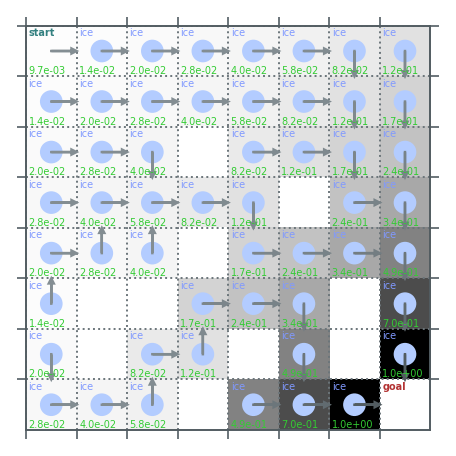

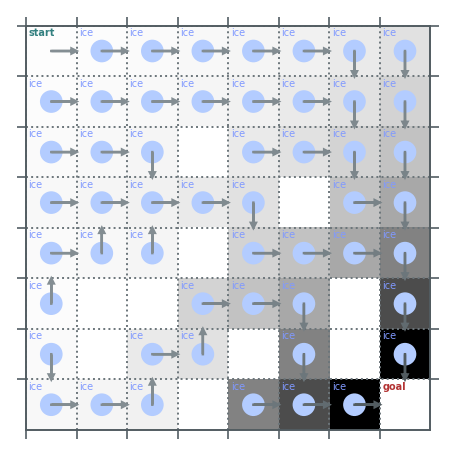

In [13]:
# do policy iteration
policy_pi, V_pi = policy_iteration(env, gamma=0.7)
rld.plot_frozenlake(env, V_pi, policy_pi, draw_vals=True)
rld.plot_frozenlake(env, V_pi, policy_pi, draw_vals=False)

In [14]:
# now lets do value iteration, which is the k=1 case but simplifies saving computation
# note how there are no intermediate policies until the end
def value_iteration(env, gamma=1, theta=1e-8):
    V = np.zeros(env.observation_space.n) # initial state value function
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            v_s = V[s] # store old value
            q_s = q_from_v(env, V, s, gamma) # the action value function is calculated for all actions
            V[s] = max(q_s) # the next value of the state function is the maximum of all action values
            delta = max(delta, abs(V[s] - v_s))
        if delta < theta: break
    # lastly, at convergence, we can get a (optimal) policy from the optimal state value function
    policy = policy_improvement(env, V, gamma)
    return policy, V

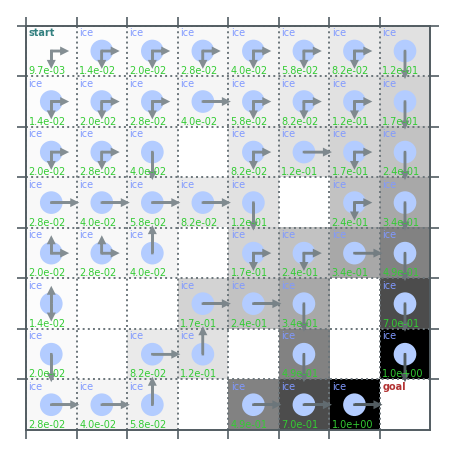

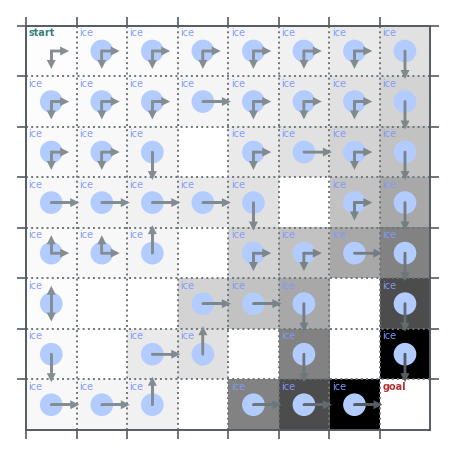

In [15]:
policy_pi, V_pi = value_iteration(env, gamma=0.7)
rld.plot_frozenlake(env, V_pi, policy_pi, draw_vals=True)
rld.plot_frozenlake(env, V_pi, policy_pi, draw_vals=False)

In [16]:
# here's an expanded version of the above that's more similar to lecture slides
def value_iteration(env, gamma=1, theta=1e-8):
    V = np.zeros(env.observation_space.n)
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            v_s = V[s]

            # one step look ahead to get q from v
            q_s = np.zeros(env.action_space.n)
            for a in range(env.action_space.n):
                for prob, next_state, reward, done in env.P[s][a]:
                    q_s[a] += prob * (reward + gamma * V[next_state])

            V[s] = max(q_s)
            delta = max(delta, abs(V[s] - v_s))
        if delta < theta: break

    policy = policy_improvement(env, V, gamma)
    return policy, V

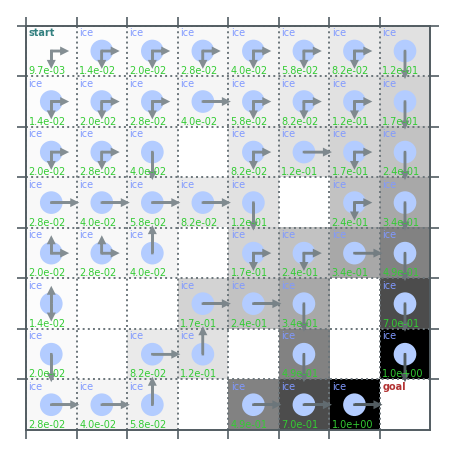

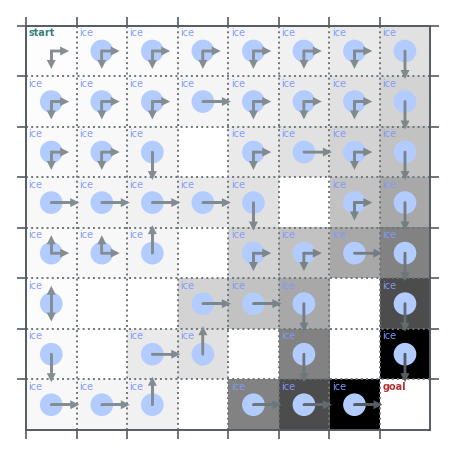

In [17]:
policy_pi, V_pi = value_iteration(env, gamma=0.7)
rld.plot_frozenlake(env, V_pi, policy_pi, draw_vals=True)
rld.plot_frozenlake(env, V_pi, policy_pi, draw_vals=False)